In [ ]:
# Download dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-07-31 00:22:31--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  76.0MB/s    in 0.9s    

2020-07-31 00:22:33 (76.0 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
# Ekstrak dataset

import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
# Definisikan path untuk data train dan data validation

base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [ ]:
import cv2
import numpy as np

# Gather data train
train_data = []
train_label = []
for r, d, f in os.walk(train_dir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (50,50))
            train_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            train_label.append(label)

train_data = np.array(train_data)
train_label = np.array(train_label)

In [ ]:
# Gather data validation
val_data = []
val_label = []
for r, d, f in os.walk(validation_dir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (50,50))
            val_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            val_label.append(label)

val_data = np.array(val_data)
val_label = np.array(val_label)

<h3>Data Preprocessing</h3>

In [ ]:
# Tampilkan shape dari data train dan data validation
print("Train Data = ", train_data.shape)
print("Train Label = ", train_label.shape)
print("Validation Data = ", val_data.shape)
print("Validation Label = ", val_label.shape)

Train Data =  (2000, 50, 50, 3)
Train Label =  (2000,)
Validation Data =  (1000, 50, 50, 3)
Validation Label =  (1000,)


In [ ]:
# Normalisasi dataset
print("Data sebelum di-normalisasi ", train_data[0][0][0])

x_train = train_data.astype('float32') / 255.0
x_val = val_data.astype('float32') / 255.0
print("Data setelah di-normalisasi ", x_train[0][0][0])

Data sebelum di-normalisasi  [100 134  86]
Data setelah di-normalisasi  [0.39215687 0.5254902  0.3372549 ]


In [ ]:
# Transformasi label encoder
from sklearn.preprocessing import LabelEncoder

print("Label sebelum di-encoder ", train_label[995:1005])

lb = LabelEncoder()
y_train = lb.fit_transform(train_label)
y_val = lb.fit_transform(val_label)

print("Label setelah di-encoder ", y_train[995:1005])

Label sebelum di-encoder  ['dogs' 'dogs' 'dogs' 'dogs' 'dogs' 'cats' 'cats' 'cats' 'cats' 'cats']
Label setelah di-encoder  [1 1 1 1 1 0 0 0 0 0]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                        height_shift_range=0.1, shear_range=0.2, 
                        zoom_range=0.8, horizontal_flip=True,
                        fill_mode="nearest")

<h3>Model Definition using VGG16</h3>

In [ ]:
# Pertama, kita import dulu library yang dibutuhkan
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
# Kita load model VGG16, kemudian kita potong bagian Top atau Fully Connected Layernya
baseModel = VGG16(include_top=False, input_tensor=Input(shape=(50, 50, 3)))

In [ ]:
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

It can be seen in model.summary() above, VGG16 has a total of 19 layers in its Feature Extraction Layer. And has 14.7 million parameters that must be trained. However, here we will use the default weight of VGG16. These weights have been pre-trained using the 'imagenet' dataset. This dataset contains a collection of image data that number in the millions. So, we don't need to retrain it.

Next, we will define our own Fully Connected Layer. We will later pair this layer with VGG16's Feature Extraction Layer

In [ ]:
class FCHeadNet:
  def build(baseModel, classes, D):
    headModel = baseModel.output
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(D, activation='elu')(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(classes, activation='sigmoid')(headModel)
    return headModel

In [ ]:
headModel = FCHeadNet.build(baseModel, 1, 256)
model = Model(inputs=baseModel.input, outputs=headModel)

So that later the model only needs to train on the weights contained in the Fully Connected Layer, then we need to freeze (*Freeze*) VGG16's Feature Extraction Layer using the code below

In [ ]:
for layer in baseModel.layers:
  layer.trainable = False

In [ ]:
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0  

In model.summary() above, it can be seen that the *trainable* parameters are only parameters belonging to the Fully Connected Layer, while the other weights that are innate from VGG16 are not trained.

<h3>Training Model<h3>

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=1e-3), 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [ ]:
H = model.fit_generator(aug.flow(x_train, y_train, batch_size=20),
                        validation_data=(x_val, y_val), epochs=15)

Epoch 1/15
100/100 [==============================] - 68s 685ms/step - loss: 0.7279 - acc: 0.5640 - val_loss: 0.5828 - val_acc: 0.6830
Epoch 2/15
100/100 [==============================] - 71s 707ms/step - loss: 0.6684 - acc: 0.6180 - val_loss: 0.5483 - val_acc: 0.7330
Epoch 3/15
100/100 [==============================] - 68s 680ms/step - loss: 0.6479 - acc: 0.6285 - val_loss: 0.6188 - val_acc: 0.6620
Epoch 4/15
100/100 [==============================] - 68s 680ms/step - loss: 0.6367 - acc: 0.6580 - val_loss: 0.5545 - val_acc: 0.7230
Epoch 5/15
100/100 [==============================] - 68s 681ms/step - loss: 0.6397 - acc: 0.6425 - val_loss: 0.5985 - val_acc: 0.6830
Epoch 6/15
100/100 [==============================] - 68s 681ms/step - loss: 0.6199 - acc: 0.6580 - val_loss: 0.5700 - val_acc: 0.6920
Epoch 7/15
100/100 [==============================] - 68s 680ms/step - loss: 0.6132 - acc: 0.6580 - val_loss: 0.5518 - val_acc: 0.7240
Epoch 8/15
100/100 [==============================] - 6

<h3>Model Evaluation</h3>

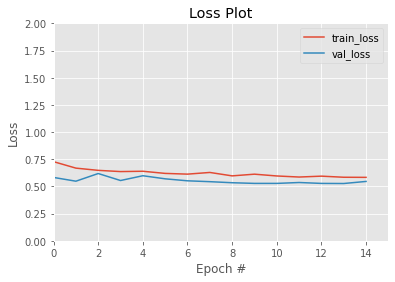

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.axis([0, 15, 0, 2])
plt.plot(np.arange(0, 15), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

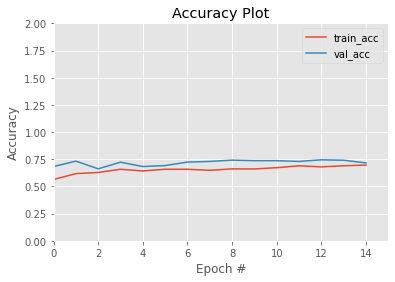

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.axis([0, 15, 0, 2])
plt.plot(np.arange(0, 15), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 15), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

pred = model.predict(x_val)
labels = (pred > 0.5).astype(np.int)

print(classification_report(y_val, labels))

              precision    recall  f1-score   support

           0       0.78      0.60      0.68       500
           1       0.67      0.83      0.75       500

    accuracy                           0.72      1000
   macro avg       0.73      0.72      0.71      1000
weighted avg       0.73      0.72      0.71      1000



<h3>Save & Load Model</h3>

In [ ]:
# save the network to disk
model.save("modelku.hdf5")

We can load the saved model by using this:

In [ ]:
from tensorflow.keras.models import load_model

my_model = load_model("modelku.hdf5")

In [ ]:
my_model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0  